In [349]:
import sys
sys.path.append("..")

import time
import pandas as pd
import matplotlib.pyplot as plt

from datasets.custom_dataset import CustomDataset

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Grayscale, ToPILImage, ToTensor, Normalize

from sklearn.model_selection import train_test_split

## Carga del set de datos

### Directorios

In [350]:
dataset_path = '../datasets/covid-19-radiography-dataset.csv'
images_path = '../datasets/unfiltered_images'

dataset = pd.read_csv(dataset_path)
dataset_file_names = dataset['file_name']
dataset_labels = dataset['label']

dataset.head()

,file_name,label
0,COVID-1.png,0
1,COVID-10.png,0
2,COVID-100.png,0
3,COVID-1000.png,0
4,COVID-1001.png,0


### Distribución de las clases en el set de datos

In [351]:
class_ids = {
    0: 'covid',
    1: 'lung_opacity',
    2: 'normal',
    3: 'viral_pneumonia'
}

def count_dataset_classes(labels, class_ids):
    class_count = {
        'covid': 0,
        'lung_opacity': 0,
        'normal': 0,
        'viral_pneumonia': 0
    }
    
    for label in labels:
        class_id = class_ids[label]
        class_count[class_id] += 1
    
    return class_count

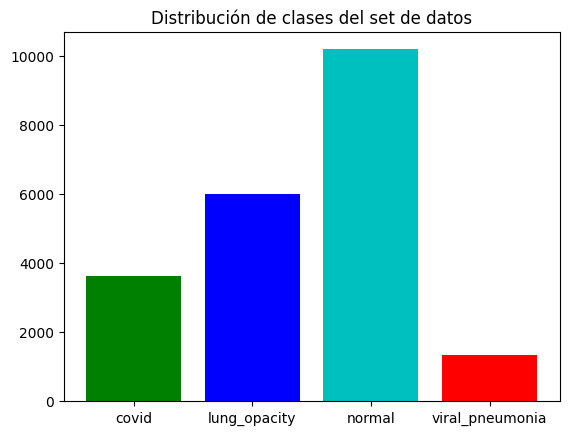

In [352]:
dataset_class_count = count_dataset_classes(dataset_labels, class_ids)

fig, ax = plt.subplots()
ax.set_title('Distribución de clases del set de datos')
ax.bar(list(dataset_class_count.keys()), list(dataset_class_count.values()), color=['g', 'b', 'c', 'r'])

plt.show()

### División del set de datos

Train set distribution:  {'covid': 2893, 'lung_opacity': 4809, 'normal': 8154, 'viral_pneumonia': 1076}
Test set distribution:  {'covid': 723, 'lung_opacity': 1203, 'normal': 2038, 'viral_pneumonia': 269}
Test vs Train distribution:  {'covid': 0.19994469026548672, 'lung_opacity': 0.2000998003992016, 'normal': 0.1999607535321821, 'viral_pneumonia': 0.2}


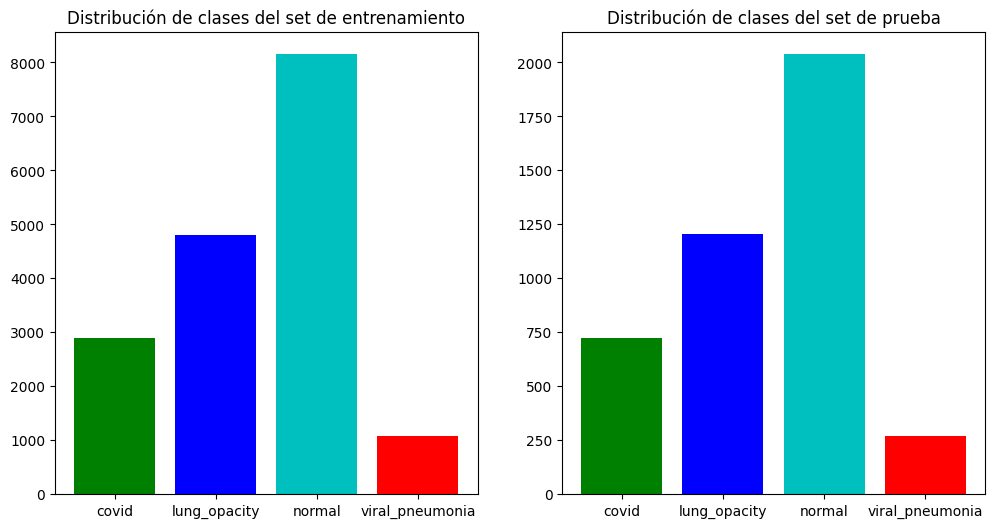

In [353]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_file_names, dataset_labels, test_size=0.2, random_state=404, stratify=dataset_labels)

train_class_count = count_dataset_classes(y_train, class_ids)
test_class_count = count_dataset_classes(y_test, class_ids)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('Distribución de clases del set de entrenamiento')
ax[0].bar(list(train_class_count.keys()), list(train_class_count.values()), color=['g', 'b', 'c', 'r'])

ax[1].set_title('Distribución de clases del set de prueba')
ax[1].bar(list(test_class_count.keys()), list(test_class_count.values()), color=['g', 'b', 'c', 'r'])

print('Train set distribution: ', train_class_count)
print('Test set distribution: ', test_class_count)
print('Test vs Train distribution: ', {k: test_class_count[k] / (dataset_class_count[k]) for k in test_class_count})
plt.show()

## Métricas de evaluación

### Definición de métricas

In [354]:
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassROC
from torchmetrics.classification import MulticlassAUROC

train_accuracy = MulticlassAccuracy(num_classes=4, average=None).to(device)
test_accuracy = MulticlassAccuracy(num_classes=4, average=None).to(device)

train_precision = MulticlassPrecision(num_classes=4, average=None).to(device)
test_precision = MulticlassPrecision(num_classes=4, average=None).to(device)

train_recall = MulticlassRecall(num_classes=4, average=None).to(device)
test_recall = MulticlassRecall(num_classes=4, average=None).to(device)

train_f1 = MulticlassF1Score(num_classes=4, average=None).to(device)
test_f1 = MulticlassF1Score(num_classes=4, average=None).to(device)

train_roc = MulticlassROC(num_classes=4).to(device)
test_roc = MulticlassROC(num_classes=4).to(device)

train_auroc = MulticlassAUROC(num_classes=4).to(device)
test_auroc = MulticlassAUROC(num_classes=4).to(device)

### Cálculo de métricas

In [355]:
def compute_metrics(train_list, test_list, train_loss, test_loss):
    train_list.append({'loss': train_loss,
                       'accuracy': train_accuracy.compute(),
                       'precision': train_precision.compute(), 
                       'recall': train_recall.compute(),
                       'f1': train_f1.compute(),
                       'roc': train_roc.compute(),
                       'auroc': train_auroc.compute()})
    
    test_list.append({'loss': test_loss,
                      'accuracy': test_accuracy.compute(),
                      'precision': test_precision.compute(),
                      'recall': test_recall.compute(),
                      'f1': test_f1.compute(),
                      'roc': test_roc.compute(),
                      'auroc': test_auroc.compute()})
    
    train_accuracy.reset()
    train_precision.reset()
    train_recall.reset()
    train_f1.reset()
    train_roc.reset()
    train_auroc.reset()
    
    test_accuracy.reset()
    test_precision.reset()
    test_recall.reset()
    test_f1.reset()
    test_roc.reset()
    test_auroc.reset()

### Gráficos de métricas

In [356]:
def show_accuracy_table(train_accuracies, test_accuracies, epochs):
    accuracy_df = pd.DataFrame({
        'Covid Train Accuracy': [train_accuracies[i][0].item() for i in range(epochs)],
        'Covid Test Accuracy': [test_accuracies[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Opacity Accuracy': [train_accuracies[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Opacity Accuracy': [test_accuracies[i][1].item() for i in range(epochs)],
        
        'Normal Train Accuracy': [train_accuracies[i][2].item() for i in range(epochs)],
        'Normal Test Accuracy': [test_accuracies[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Accuracy': [train_accuracies[i][3].item() for i in range(epochs)],
        'Pneumonia Test Accuracy': [test_accuracies[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    accuracy_df.index.name = 'Epoch'
    display(accuracy_df)

In [357]:
def show_precision_table(train_precisions, test_precisions, epochs):
    precision_df = pd.DataFrame({
        'Covid Train Precision': [train_precisions[i][0].item() for i in range(epochs)],
        'Covid Test Precision': [test_precisions[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Opacity Precision': [train_precisions[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Opacity Precision': [test_precisions[i][1].item() for i in range(epochs)],
        
        'Normal Train Precision': [train_precisions[i][2].item() for i in range(epochs)],
        'Normal Test Precision': [test_precisions[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Precision': [train_precisions[i][3].item() for i in range(epochs)],
        'Pneumonia Test Precision': [test_precisions[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    precision_df.index.name = 'Epoch'
    display(precision_df)

In [358]:
def show_recall_table(train_recalls, test_recalls, epochs):
    recall_df = pd.DataFrame({
        'Covid Train Recall': [train_recalls[i][0].item() for i in range(epochs)],
        'Covid Test Recall': [test_recalls[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Opacity Recall': [train_recalls[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Opacity Recall': [test_recalls[i][1].item() for i in range(epochs)],
        
        'Normal Train Recall': [train_recalls[i][2].item() for i in range(epochs)],
        'Normal Test Recall': [test_recalls[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Recall': [train_recalls[i][3].item() for i in range(epochs)],
        'Pneumonia Test Recall': [test_recalls[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    recall_df.index.name = 'Epoch'
    display(recall_df)

In [359]:
def show_f1_score_table(train_f1_scores, test_f1_scores, epochs):
    f1_score_df = pd.DataFrame({
        'Covid Train F1-Score': [train_f1_scores[i][0].item() for i in range(epochs)],
        'Covid Test F1-Score': [test_f1_scores[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Opacity F1-Score': [train_f1_scores[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Opacity F1-Score': [test_f1_scores[i][1].item() for i in range(epochs)],
        
        'Normal Train F1-Score': [train_f1_scores[i][2].item() for i in range(epochs)],
        'Normal Test F1-Score': [test_f1_scores[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train F1-Score': [train_f1_scores[i][3].item() for i in range(epochs)],
        'Pneumonia Test F1-Score': [test_f1_scores[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])
    
    f1_score_df.index.name = 'Epoch'
    display(f1_score_df) 

In [360]:
def show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    ax[0, 0].set_title('ROC Curve for Covid')
    ax[0, 0].set_ylabel('TPR')
    ax[0, 0].set_xlabel('FPR')

    ax[0, 1].set_title('ROC Curve for Lung Opacity')
    ax[0, 1].set_ylabel('TPR')
    ax[0, 1].set_xlabel('FPR')

    ax[1, 0].set_title('ROC Curve for Normal')
    ax[1, 0].set_ylabel('TPR')
    ax[1, 0].set_xlabel('FPR')

    ax[1, 1].set_title('ROC Curve for Pneumonia')
    ax[1, 1].set_ylabel('TPR')
    ax[1, 1].set_xlabel('FPR')

    ax[0, 0].plot(train_roc_fpr[0], train_roc_tpr[0], label='Train', color='b')
    ax[0, 0].plot(test_roc_fpr[0], test_roc_tpr[0], label='Test', color='g')

    ax[0, 1].plot(train_roc_fpr[1], train_roc_tpr[1], label='Train', color='b')
    ax[0, 1].plot(test_roc_fpr[1], test_roc_tpr[1], label='Test', color='g')

    ax[1, 0].plot(train_roc_fpr[2], train_roc_tpr[2], label='Train', color='b')
    ax[1, 0].plot(test_roc_fpr[2], test_roc_tpr[2], label='Test', color='g')

    ax[1, 1].plot(train_roc_fpr[3], train_roc_tpr[3], label='Train', color='b')
    ax[1, 1].plot(test_roc_fpr[3], test_roc_tpr[3], label='Test', color='g')

    ax[0, 0].legend()
    ax[0, 1].legend()
    ax[1, 0].legend()
    ax[1, 1].legend()
    fig.show()

In [361]:
def show_learning_curve(train_losses, test_losses, epoch_list):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Loss vs Epoch')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_xticks(epoch_list)

    ax.plot(epoch_list, train_losses, label='Train', color='b', marker='o')
    ax.plot(epoch_list, test_losses, label='Test', color='g', marker='o')

    ax.legend()
    fig.show()

## Definicición del modelo


### Uso de GPU si está disponible

In [362]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


### Arquitectura del modelo

In [363]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Dropout(p=0.3),
            
            nn.Linear(in_features=88209, out_features=4),
            nn.ReLU(),
            
            
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            # nn.ReLU(),
            
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            # nn.ReLU(),
            
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.ReLU(),

            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            # nn.ReLU(),

            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            # nn.ReLU(),
            
            # nn.Flatten(),
            # nn.Dropout(p=0.3),
            
            # nn.Linear(in_features=1600, out_features=4096),
            # nn.ReLU(),
            
            # nn.Linear(in_features=4096, out_features=40),
            # nn.ReLU(),
        )

    def forward(self, x):
        logits = self.sequential(x)
        return logits

## Entrenamiento del modelo

### Función de entrenamiento

In [364]:
def train(dataloader, model, loss_fn, optimizer):
    print('--------------------------- Training --------------------------\n')
    size = len(dataloader.dataset)
    loss = torch.Tensor([0]).to(device)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        
        train_accuracy.update(pred, y)
        train_precision.update(pred, y)
        train_recall.update(pred, y)
        train_f1.update(pred, y)    
        train_roc.update(pred, y)
        train_auroc.update(pred, y)
        
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f'Current Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
    
    return loss.item()

### Función de evaluación

In [365]:
def test(dataloader, model, loss_fn):
    print('--------------------------- Testing ---------------------------\n')
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            test_accuracy.update(pred, y)
            test_precision.update(pred, y)
            test_recall.update(pred, y)
            test_f1.update(pred, y)    
            test_roc.update(pred, y)
            test_auroc.update(pred, y)
            
            test_loss += loss_fn(pred, y).item()
            
    test_loss /= num_batches
    accuracy_df = pd.DataFrame({
        'Covid Test Accuracy': [test_accuracy.compute()[0].item()],
        'Lung-Opacity Test Opacity Accuracy': [test_accuracy.compute()[1].item()],
        'Normal Test Accuracy': [test_accuracy.compute()[2].item()],
        'Pneumonia Test Accuracy': [test_accuracy.compute()[3].item()]
    })
    display(accuracy_df)
    return test_loss

### Ciclo de entrenamiento

In [366]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.2
epochs = 10

train_dataset = CustomDataset(images_path, X_train, y_train, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    Normalize(0.5, 0.5)
]))

test_dataset = CustomDataset(images_path, X_test, y_test, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    Normalize(0.5, 0.5)
]))

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True)

model = ConvolutionalNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [367]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.427649  [   32/16932]
Current Loss: 1.349360  [  352/16932]
Current Loss: 1.366998  [  672/16932]
Current Loss: 1.338611  [  992/16932]
Current Loss: 1.327668  [ 1312/16932]
Current Loss: 1.347361  [ 1632/16932]
Current Loss: 1.331579  [ 1952/16932]
Current Loss: 1.293938  [ 2272/16932]
Current Loss: 1.277205  [ 2592/16932]
Current Loss: 1.318990  [ 2912/16932]
Current Loss: 1.247110  [ 3232/16932]
Current Loss: 1.339133  [ 3552/16932]
Current Loss: 1.215695  [ 3872/16932]
Current Loss: 1.276044  [ 4192/16932]
Current Loss: 1.266368  [ 4512/16932]
Current Loss: 1.243844  [ 4832/16932]
Current Loss: 1.202935  [ 5152/16932]
Current Loss: 1.249622  [ 5472/16932]
Current Loss: 1.193776  [ 5792/16932]
Current Loss: 1.248458  [ 6112/16932]
Current Loss: 1.230445  [ 6432/16932]
Current Loss: 1.396788  [ 6752/16932]
Current Loss: 1.266469  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.004156,0.998037,0.0


--------------------------- Epoch 2 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.301086  [   32/16932]
Current Loss: 1.367298  [  352/16932]
Current Loss: 1.137394  [  672/16932]
Current Loss: 1.203750  [  992/16932]
Current Loss: 1.188560  [ 1312/16932]
Current Loss: 1.158850  [ 1632/16932]
Current Loss: 1.187249  [ 1952/16932]
Current Loss: 1.093496  [ 2272/16932]
Current Loss: 1.189111  [ 2592/16932]
Current Loss: 1.340540  [ 2912/16932]
Current Loss: 1.179476  [ 3232/16932]
Current Loss: 1.190577  [ 3552/16932]
Current Loss: 1.181300  [ 3872/16932]
Current Loss: 1.103323  [ 4192/16932]
Current Loss: 1.174579  [ 4512/16932]
Current Loss: 0.997904  [ 4832/16932]
Current Loss: 1.341163  [ 5152/16932]
Current Loss: 1.057731  [ 5472/16932]
Current Loss: 1.133410  [ 5792/16932]
Current Loss: 1.266075  [ 6112/16932]
Current Loss: 1.065817  [ 6432/16932]
Current Loss: 1.070174  [ 6752/16932]
Current Loss: 1.136062  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.008299,0.014963,0.995093,0.0


--------------------------- Epoch 3 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.110414  [   32/16932]
Current Loss: 1.131851  [  352/16932]
Current Loss: 1.258687  [  672/16932]
Current Loss: 1.003094  [  992/16932]
Current Loss: 1.153004  [ 1312/16932]
Current Loss: 1.095694  [ 1632/16932]
Current Loss: 1.148595  [ 1952/16932]
Current Loss: 1.132298  [ 2272/16932]
Current Loss: 1.150168  [ 2592/16932]
Current Loss: 1.021989  [ 2912/16932]
Current Loss: 1.081499  [ 3232/16932]
Current Loss: 1.219536  [ 3552/16932]
Current Loss: 1.094778  [ 3872/16932]
Current Loss: 1.292861  [ 4192/16932]
Current Loss: 1.218733  [ 4512/16932]
Current Loss: 1.091248  [ 4832/16932]
Current Loss: 1.087070  [ 5152/16932]
Current Loss: 1.110770  [ 5472/16932]
Current Loss: 1.087870  [ 5792/16932]
Current Loss: 1.158847  [ 6112/16932]
Current Loss: 1.065501  [ 6432/16932]
Current Loss: 1.162902  [ 6752/16932]
Current Loss: 1.043689  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.017981,0.126351,0.980373,0.0


--------------------------- Epoch 4 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.105818  [   32/16932]
Current Loss: 1.132831  [  352/16932]
Current Loss: 1.138266  [  672/16932]
Current Loss: 1.140255  [  992/16932]
Current Loss: 1.158741  [ 1312/16932]
Current Loss: 1.023117  [ 1632/16932]
Current Loss: 1.208557  [ 1952/16932]
Current Loss: 1.105623  [ 2272/16932]
Current Loss: 1.194632  [ 2592/16932]
Current Loss: 1.097216  [ 2912/16932]
Current Loss: 1.141810  [ 3232/16932]
Current Loss: 1.146853  [ 3552/16932]
Current Loss: 1.079559  [ 3872/16932]
Current Loss: 1.146265  [ 4192/16932]
Current Loss: 1.074261  [ 4512/16932]
Current Loss: 1.054939  [ 4832/16932]
Current Loss: 0.998365  [ 5152/16932]
Current Loss: 0.926211  [ 5472/16932]
Current Loss: 1.177397  [ 5792/16932]
Current Loss: 1.255901  [ 6112/16932]
Current Loss: 1.182117  [ 6432/16932]
Current Loss: 1.098953  [ 6752/16932]
Current Loss: 1.145383  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.030429,0.217789,0.969087,0.0


--------------------------- Epoch 5 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.055794  [   32/16932]
Current Loss: 1.155082  [  352/16932]
Current Loss: 1.084747  [  672/16932]
Current Loss: 1.046046  [  992/16932]
Current Loss: 1.097881  [ 1312/16932]
Current Loss: 1.001698  [ 1632/16932]
Current Loss: 1.051363  [ 1952/16932]
Current Loss: 1.073728  [ 2272/16932]
Current Loss: 0.928221  [ 2592/16932]
Current Loss: 1.050317  [ 2912/16932]
Current Loss: 1.112582  [ 3232/16932]
Current Loss: 1.218953  [ 3552/16932]
Current Loss: 1.148835  [ 3872/16932]
Current Loss: 1.038301  [ 4192/16932]
Current Loss: 1.045691  [ 4512/16932]
Current Loss: 0.999587  [ 4832/16932]
Current Loss: 1.043476  [ 5152/16932]
Current Loss: 1.113263  [ 5472/16932]
Current Loss: 1.103893  [ 5792/16932]
Current Loss: 1.156407  [ 6112/16932]
Current Loss: 1.102618  [ 6432/16932]
Current Loss: 1.152358  [ 6752/16932]
Current Loss: 1.006657  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.033195,0.322527,0.95682,0.0


--------------------------- Epoch 6 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.003448  [   32/16932]
Current Loss: 1.017445  [  352/16932]
Current Loss: 1.101031  [  672/16932]
Current Loss: 1.113079  [  992/16932]
Current Loss: 0.973368  [ 1312/16932]
Current Loss: 0.880501  [ 1632/16932]
Current Loss: 0.993114  [ 1952/16932]
Current Loss: 1.100662  [ 2272/16932]
Current Loss: 0.936764  [ 2592/16932]
Current Loss: 1.084860  [ 2912/16932]
Current Loss: 0.963180  [ 3232/16932]
Current Loss: 1.120656  [ 3552/16932]
Current Loss: 1.069944  [ 3872/16932]
Current Loss: 0.908308  [ 4192/16932]
Current Loss: 1.052810  [ 4512/16932]
Current Loss: 1.248162  [ 4832/16932]
Current Loss: 1.121714  [ 5152/16932]
Current Loss: 1.074034  [ 5472/16932]
Current Loss: 0.928610  [ 5792/16932]
Current Loss: 0.979870  [ 6112/16932]
Current Loss: 0.965572  [ 6432/16932]
Current Loss: 0.996095  [ 6752/16932]
Current Loss: 1.095636  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.059474,0.348296,0.94897,0.0


--------------------------- Epoch 7 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.968082  [   32/16932]
Current Loss: 0.919399  [  352/16932]
Current Loss: 1.002617  [  672/16932]
Current Loss: 0.998111  [  992/16932]
Current Loss: 1.029625  [ 1312/16932]
Current Loss: 1.016460  [ 1632/16932]
Current Loss: 1.050125  [ 1952/16932]
Current Loss: 1.026265  [ 2272/16932]
Current Loss: 1.055197  [ 2592/16932]
Current Loss: 0.990237  [ 2912/16932]
Current Loss: 0.946090  [ 3232/16932]
Current Loss: 1.014685  [ 3552/16932]
Current Loss: 1.047101  [ 3872/16932]
Current Loss: 1.075359  [ 4192/16932]
Current Loss: 0.988948  [ 4512/16932]
Current Loss: 0.923116  [ 4832/16932]
Current Loss: 1.027499  [ 5152/16932]
Current Loss: 1.045600  [ 5472/16932]
Current Loss: 0.969226  [ 5792/16932]
Current Loss: 1.093270  [ 6112/16932]
Current Loss: 0.911127  [ 6432/16932]
Current Loss: 1.152089  [ 6752/16932]
Current Loss: 0.737112  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.087137,0.444722,0.935721,0.0


--------------------------- Epoch 8 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.928835  [   32/16932]
Current Loss: 1.106229  [  352/16932]
Current Loss: 1.058352  [  672/16932]
Current Loss: 0.945342  [  992/16932]
Current Loss: 0.912943  [ 1312/16932]
Current Loss: 0.896333  [ 1632/16932]
Current Loss: 1.074080  [ 1952/16932]
Current Loss: 1.079771  [ 2272/16932]
Current Loss: 1.147547  [ 2592/16932]
Current Loss: 1.051789  [ 2912/16932]
Current Loss: 1.023860  [ 3232/16932]
Current Loss: 0.957020  [ 3552/16932]
Current Loss: 0.941287  [ 3872/16932]
Current Loss: 1.200918  [ 4192/16932]
Current Loss: 1.020813  [ 4512/16932]
Current Loss: 1.388072  [ 4832/16932]
Current Loss: 0.968074  [ 5152/16932]
Current Loss: 0.977477  [ 5472/16932]
Current Loss: 0.930049  [ 5792/16932]
Current Loss: 1.132761  [ 6112/16932]
Current Loss: 1.119542  [ 6432/16932]
Current Loss: 1.045259  [ 6752/16932]
Current Loss: 0.898892  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.091286,0.482128,0.924436,0.0


--------------------------- Epoch 9 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.146351  [   32/16932]
Current Loss: 0.873693  [  352/16932]
Current Loss: 0.986023  [  672/16932]
Current Loss: 1.080501  [  992/16932]
Current Loss: 1.042816  [ 1312/16932]
Current Loss: 1.180497  [ 1632/16932]
Current Loss: 0.918829  [ 1952/16932]
Current Loss: 0.903519  [ 2272/16932]
Current Loss: 1.067438  [ 2592/16932]
Current Loss: 0.964037  [ 2912/16932]
Current Loss: 0.750591  [ 3232/16932]
Current Loss: 1.014756  [ 3552/16932]
Current Loss: 0.904024  [ 3872/16932]
Current Loss: 0.998499  [ 4192/16932]
Current Loss: 1.036346  [ 4512/16932]
Current Loss: 0.954952  [ 4832/16932]
Current Loss: 0.900669  [ 5152/16932]
Current Loss: 1.012628  [ 5472/16932]
Current Loss: 1.110838  [ 5792/16932]
Current Loss: 0.990891  [ 6112/16932]
Current Loss: 1.158588  [ 6432/16932]
Current Loss: 0.957006  [ 6752/16932]
Current Loss: 1.111238  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.089903,0.498753,0.924436,0.0


--------------------------- Epoch 10 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.057104  [   32/16932]
Current Loss: 0.862494  [  352/16932]
Current Loss: 1.093372  [  672/16932]
Current Loss: 0.888932  [  992/16932]
Current Loss: 0.871589  [ 1312/16932]
Current Loss: 1.113468  [ 1632/16932]
Current Loss: 0.956157  [ 1952/16932]
Current Loss: 0.758354  [ 2272/16932]
Current Loss: 0.782280  [ 2592/16932]
Current Loss: 1.114986  [ 2912/16932]
Current Loss: 1.123683  [ 3232/16932]
Current Loss: 1.019612  [ 3552/16932]
Current Loss: 0.967837  [ 3872/16932]
Current Loss: 1.054593  [ 4192/16932]
Current Loss: 1.006407  [ 4512/16932]
Current Loss: 0.862251  [ 4832/16932]
Current Loss: 0.839523  [ 5152/16932]
Current Loss: 0.909159  [ 5472/16932]
Current Loss: 1.122797  [ 5792/16932]
Current Loss: 1.082443  [ 6112/16932]
Current Loss: 1.066860  [ 6432/16932]
Current Loss: 0.969971  [ 6752/16932]
Current Loss: 1.284258  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.131397,0.551122,0.902355,0.0


Training time: 23.006 minutes


## Evaluación del modelo

### Curva de entrenamiento

/tmp/ipykernel_1732/1119352215.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


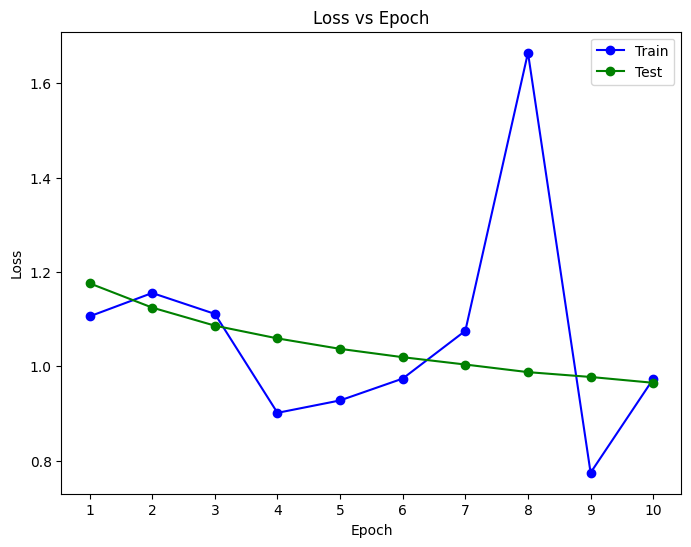

In [368]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [369]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Opacity Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.007950,0.000000,0.081514,0.004156,0.932794,0.998037,0.0,0.0
2,0.005185,0.008299,0.018299,0.014963,0.993500,0.995093,0.0,0.0
3,0.010370,0.017981,0.080266,0.126351,0.983934,0.980373,0.0,0.0
4,0.023851,0.030429,0.200665,0.217789,0.964803,0.969087,0.0,0.0
5,0.044936,0.033195,0.298399,0.322527,0.949105,0.956820,0.0,0.0
6,0.058071,0.059474,0.379289,0.348296,0.931813,0.948970,0.0,0.0
7,0.081576,0.087137,0.411104,0.444722,0.923718,0.935721,0.0,0.0
8,0.105081,0.091286,0.457268,0.482128,0.912436,0.924436,0.0,0.0
9,0.121673,0.089903,0.486380,0.498753,0.905323,0.924436,0.0,0.0


### Precision

In [370]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Opacity Precision,Lung-Opacity Test Opacity Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.214953,0.000000,0.328583,0.238095,0.487033,0.482906,0.0,0.0
2,0.405405,0.666667,0.409302,0.382979,0.485671,0.485516,0.0,0.0
3,0.500000,0.764706,0.545969,0.598425,0.496381,0.504291,0.0,0.0
4,0.514925,0.536585,0.590937,0.613583,0.518829,0.524568,0.0,0.0
5,0.474453,0.558140,0.608309,0.630894,0.541302,0.545455,0.0,0.0
6,0.456522,0.443299,0.601187,0.629129,0.561650,0.557349,0.0,0.0
7,0.454721,0.456522,0.600364,0.625731,0.574129,0.588580,0.0,0.0
8,0.476489,0.448980,0.601313,0.616366,0.588794,0.599046,0.0,0.0
9,0.463158,0.460993,0.599436,0.615385,0.601630,0.604427,0.0,0.0


### Recall

In [371]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Opacity Recall,Lung-Opacity Test Opacity Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.007950,0.000000,0.081514,0.004156,0.932794,0.998037,0.0,0.0
2,0.005185,0.008299,0.018299,0.014963,0.993500,0.995093,0.0,0.0
3,0.010370,0.017981,0.080266,0.126351,0.983934,0.980373,0.0,0.0
4,0.023851,0.030429,0.200665,0.217789,0.964803,0.969087,0.0,0.0
5,0.044936,0.033195,0.298399,0.322527,0.949105,0.956820,0.0,0.0
6,0.058071,0.059474,0.379289,0.348296,0.931813,0.948970,0.0,0.0
7,0.081576,0.087137,0.411104,0.444722,0.923718,0.935721,0.0,0.0
8,0.105081,0.091286,0.457268,0.482128,0.912436,0.924436,0.0,0.0
9,0.121673,0.089903,0.486380,0.498753,0.905323,0.924436,0.0,0.0


### F1-Score

In [372]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train Opacity F1-Score,Lung-Opacity Test Opacity F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.015333,0.000000,0.130623,0.008170,0.639939,0.650880,0.0,0.0
2,0.010239,0.016393,0.035032,0.028800,0.652412,0.652615,0.0,0.0
3,0.020318,0.035135,0.139956,0.208648,0.659868,0.666000,0.0,0.0
4,0.045590,0.057592,0.299596,0.321472,0.674787,0.680682,0.0,0.0
5,0.082097,0.062663,0.400391,0.426843,0.689412,0.694816,0.0,0.0
6,0.103036,0.104878,0.465128,0.448368,0.700858,0.702251,0.0,0.0
7,0.138335,0.146341,0.488028,0.519922,0.708128,0.722622,0.0,0.0
8,0.172189,0.151724,0.519490,0.541045,0.715729,0.726992,0.0,0.0
9,0.192718,0.150463,0.537022,0.550964,0.722875,0.730941,0.0,0.0


### Gráfico ROC para cada clase

/tmp/ipykernel_1732/2518052900.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


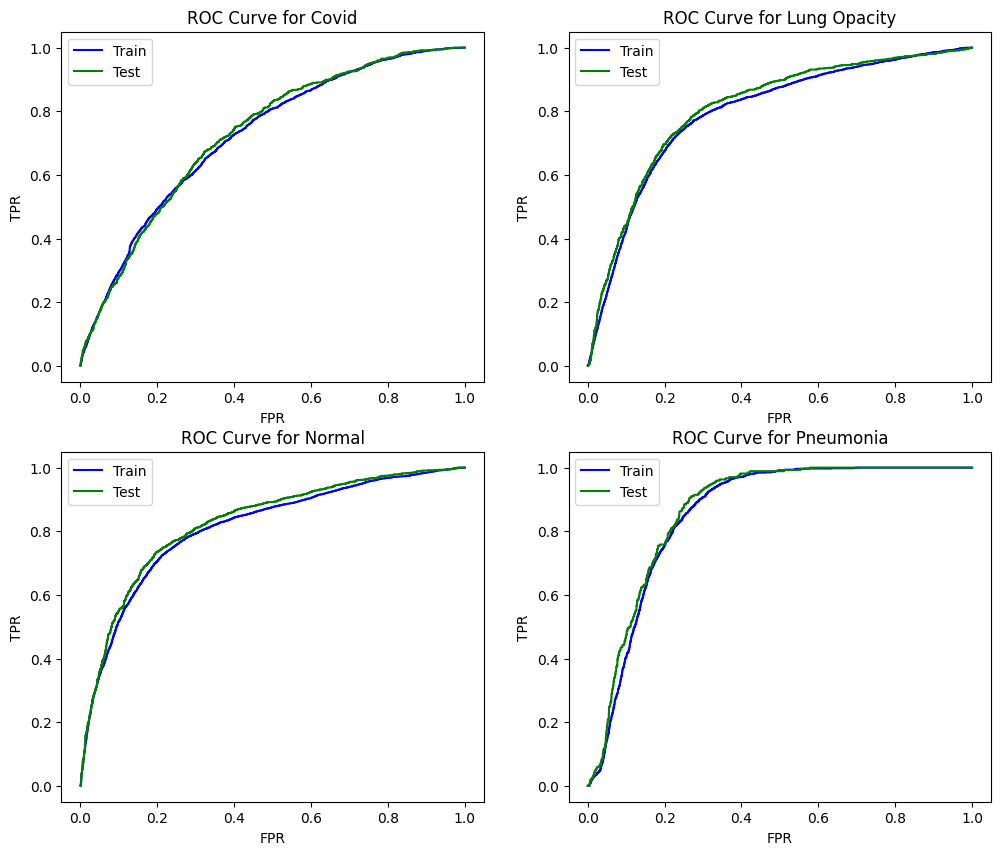

In [373]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

## Saliency Maps

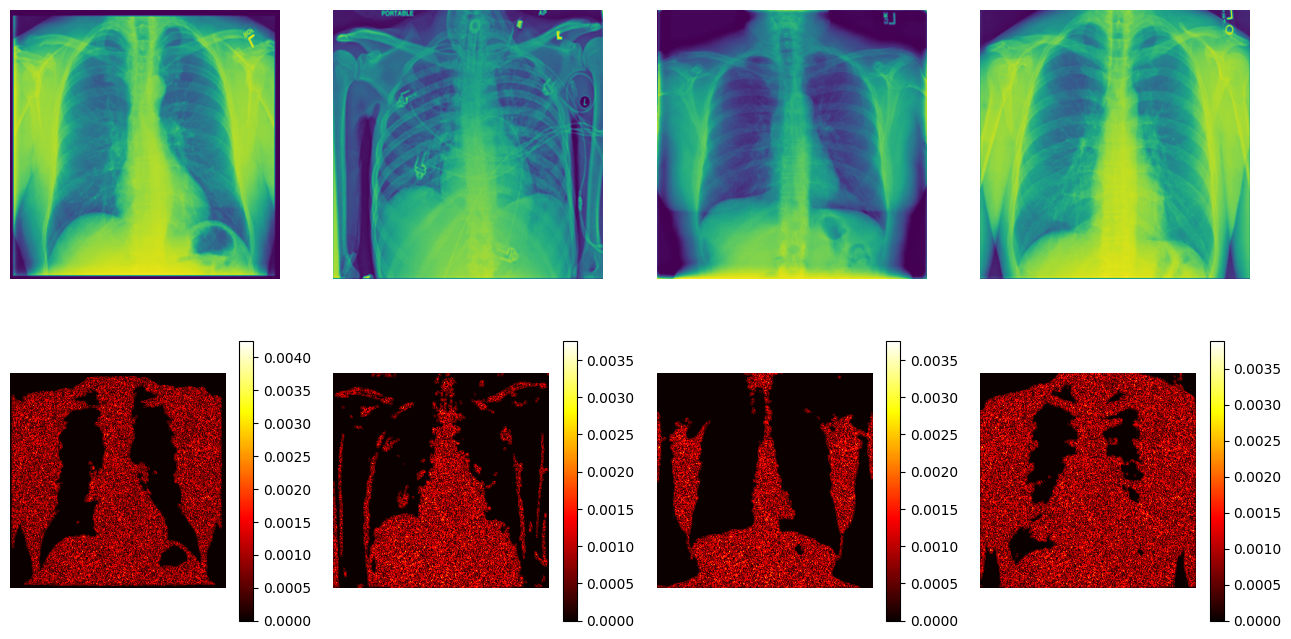

In [433]:
model.eval()

X_test = next(iter(test_dataloader))

num_samples = 4

fig, ax = plt.subplots(2, num_samples, figsize=(16, 8))

for i in range(num_samples):
    current_sample = X_test[0][i]
    
    current_sample.requires_grad_()

    scores = model(current_sample)

    score_max_index = scores[0].argmax()
    score_max = scores[0, score_max_index.item()]

    score_max.backward()

    X_test_grad = current_sample.grad.abs()

    X_test_grad = X_test_grad.detach().numpy()
    
    ax[0, i].imshow(current_sample[0].detach().numpy())
    ax[0, i].axis('off')

    img = ax[1, i].imshow(X_test_grad[0], cmap=plt.cm.hot)
    ax[1, i].axis('off')
    fig.colorbar(img, ax=ax[1, i])

plt.show()